# Do time/distance cells really exist?
Compare information content from elapsed time and distance travelled with that of shuffled data

In [22]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('plot_style.mplstyle')

import yaml
import numpy as np
import pingouin as pg
import pandas as pd
from tqdm import tqdm
import h5py
import os


from functions.dataloaders import load_data
from functions.signal_processing import preprocess_data
from functions.tuning import extract_1D_tuning, extract_2D_tuning, extract_discrete_tuning

# Params
with open('params.yaml','r') as file:
    params = yaml.full_load(file)

# Seed for reproducibility
np.random.seed(params['seed'])

In [6]:
session = '../../datasets/calcium_imaging/CA1/M246/M246_OF_1'
data = load_data(session)
data = preprocess_data(data,params)

In [25]:
AMI, p_value, occupancy_frames, active_frames_in_bin, tuning_curves = extract_1D_tuning(data['binaryData'],
                                                            data['elapsed_time'],
                                                            data['running_ts'],
                                                            var_length=params['max_temporal_length'],
                                                            bin_size=params['temporalBinSize'])

shuffled_AMI = np.zeros((params['num_surrogates'],data['binaryData'].shape[1]))
shuffled_pvalue = np.zeros((params['num_surrogates'],data['binaryData'].shape[1]))

for shuffle_i in tqdm(range(params['num_surrogates'])):
    idx = np.random.randint(len(data['elapsed_time']))
    shuffled_time = np.concatenate((data['elapsed_time'][idx:], data['elapsed_time'][:idx]))

    shuffled_AMI[shuffle_i,:], shuffled_pvalue[shuffle_i,:], _, _, _ = extract_1D_tuning(data['binaryData'],
                                            shuffled_time,
                                            data['running_ts'],
                                            var_length=params['max_temporal_length'],
                                            bin_size=params['temporalBinSize'])

100%|██████████| 1000/1000 [29:40<00:00,  1.78s/it]


In [26]:
# Save data
if not os.path.exists(os.path.join(params['path_to_results'],'tuning_significance')):
    os.mkdir(os.path.join(params['path_to_results'],'tuning_significance'))

if not os.path.exists(os.path.join(params['path_to_results'],'tuning_significance','elapsed_time_significance.h5')): # Do not overwrite
    with h5py.File(os.path.join(params['path_to_results'],'tuning_significance','elapsed_time_significance.h5'),'w') as f:
        f.create_dataset('actual_AMI', data=AMI)
        f.create_dataset('actual_pvalue', data=p_value)
        f.create_dataset('shuffled_AMI', data=shuffled_AMI)
        f.create_dataset('shuffled_pvalue', data=shuffled_pvalue)

Text(0.5, 1.0, 'Elapsed time')

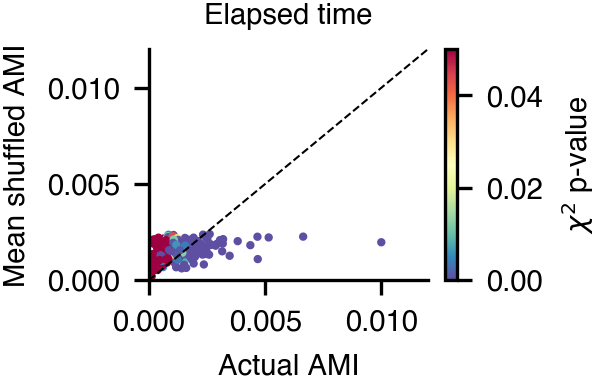

In [34]:
# Plot scatter: y=real AMI, x=mean(shuffled_AMI), c=actual p_value
plt.scatter(x=AMI,y=np.mean(shuffled_AMI,axis=0),c=p_value,cmap='Spectral_r',vmin=0,vmax=.05)
plt.colorbar(label='$\chi^2$ p-value')
plt.xlim([0,0.012])
plt.ylim([0,0.012])
plt.plot([0,0.012],[0,0.012],'k--')
plt.xlabel('Actual AMI')
plt.ylabel('Mean shuffled AMI')
plt.title('Elapsed time')

In [38]:
len(np.mean(shuffled_AMI,axis=0))

302

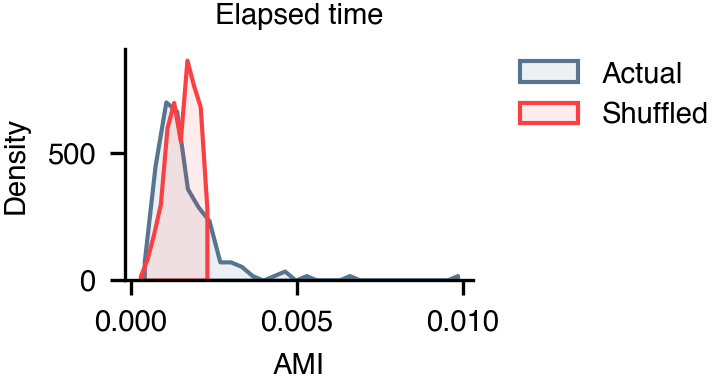

In [60]:
# Temporal coding with or without tones
sns.histplot(AMI[p_value<0.05],
             stat='density',
             element='poly',
             alpha=.1,
             label='Actual',
             color='C0')
sns.histplot(np.mean(shuffled_AMI,axis=0),
            stat='density',
             element='poly',
             alpha=.1,
             label='Shuffled',
             color='C6')
#plt.xscale('log')
plt.title('Elapsed time')
plt.xlabel('AMI')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)

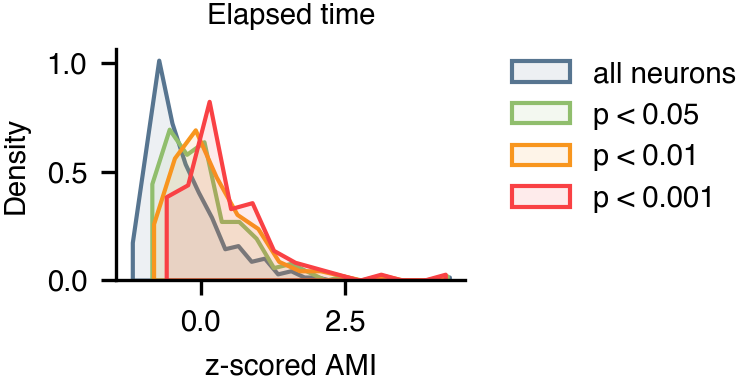

In [65]:
sns.histplot((AMI-np.mean(shuffled_AMI,axis=0))/np.std(shuffled_AMI,axis=0),
             stat='density',
             element='poly',
             alpha=.1,
             label='all neurons',
             color='C0')
sns.histplot((AMI[p_value<0.05]-np.mean(shuffled_AMI,axis=0)[p_value<0.05])/np.std(shuffled_AMI,axis=0)[p_value<0.05],
             stat='density',
             element='poly',
             alpha=.1,
             label='p < 0.05',
             color='C2')
sns.histplot((AMI[p_value<0.01]-np.mean(shuffled_AMI,axis=0)[p_value<0.01])/np.std(shuffled_AMI,axis=0)[p_value<0.01],
             stat='density',
             element='poly',
             alpha=.1,
             label='p < 0.01',
             color='C4')
sns.histplot((AMI[p_value<0.001]-np.mean(shuffled_AMI,axis=0)[p_value<0.001])/np.std(shuffled_AMI,axis=0)[p_value<0.001],
             stat='density',
             element='poly',
             alpha=.1,
             label='p < 0.001',
             color='C6')
#plt.xscale('log')
plt.title('Elapsed time')
plt.xlabel('z-scored AMI')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)

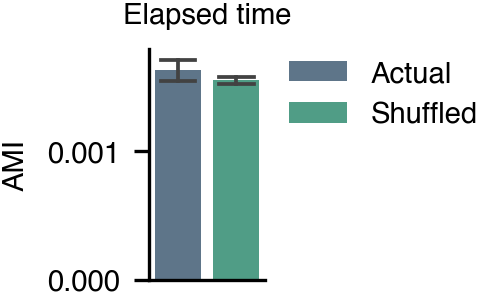

In [61]:
# Temporal coding with or without tones
plt.figure(figsize=(.5,1))
sns.barplot([AMI[p_value<0.05],np.mean(shuffled_AMI,axis=0)],
             label=['Actual','Shuffled'],
             errorbar='se',
             capsize=.6,
             hue_order=['Actual','Shuffled']
             )

plt.title('Elapsed time')
plt.ylabel('AMI')
plt.xticks([])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)